## Machine Learning 프로젝트 수행을 위한 코드 구조화

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [ ]:
# 설치에 필요한 라이브러리들이 있다면 모두 적어둡니다. anaconda에 기본적으로 설치되지 않은 라이브러리들을 적어두세요.
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [ ]:
# flag setting
feature_reducing = False # 'pca' or 'fi'
finalize = 'kfolds' # 'single' or 'kfolds'

In [ ]:
# 데이터를 불러옵니다.
base_path = '/content/drive/MyDrive/Colab Notebooks/data/energy_usage_2023/'
train = pd.read_csv(base_path + 'train.csv')
building_info = pd.read_csv(base_path + 'building_info.csv')
test = pd.read_csv(base_path + 'test.csv')
print(train.shape, building_info.shape, test.shape)

(204000, 10) (100, 7) (16800, 7)


## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

In [ ]:
train.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'],
      dtype='object')

In [ ]:
## On your Own
#display(train.head())
#test.head()
#sns.heatmap(train.corr(), annot=True, fmt='.3f')
#sns.heatmap(test.corr(), annot=True, fmt='.3f')
train = train.drop(columns=['일조(hr)', '일사(MJ/m2)'])
train.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation',
                 'windspeed', 'humidity', 'target']
test.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation',
                 'windspeed', 'humidity']

In [ ]:
building_info.loc[building_info['태양광용량(kW)'] == '-', '태양광용량(kW)'] = 0
building_info.loc[building_info['ESS저장용량(kWh)'] == '-', 'ESS저장용량(kWh)'] = 0
building_info.loc[building_info['PCS용량(kW)'] == '-', 'PCS용량(kW)'] = 0

building_info['태양광용량(kW)'] = building_info['태양광용량(kW)'].astype('float')
building_info['ESS저장용량(kWh)'] = building_info['ESS저장용량(kWh)'].astype('float')
building_info['PCS용량(kW)'] = building_info['PCS용량(kW)'].astype('float')

building_info.columns = ['num', 'type', 'area1', 'area2', 'solar', 'ESS', 'PCS']
building_info

,num,type,area1,area2,solar,ESS,PCS
0,1,건물기타,110634.00,39570.00,0.0,0.0,0.0
1,2,건물기타,122233.47,99000.00,0.0,0.0,0.0
2,3,건물기타,171243.00,113950.00,40.0,0.0,0.0
3,4,건물기타,74312.98,34419.62,60.0,0.0,0.0
4,5,건물기타,205884.00,150000.00,0.0,2557.0,1000.0
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,0.0,0.0,0.0
96,97,호텔및리조트,55144.67,25880.00,0.0,0.0,0.0
97,98,호텔및리조트,53578.62,17373.75,0.0,0.0,0.0
98,99,호텔및리조트,53499.00,40636.00,0.0,0.0,0.0


In [ ]:
train = pd.merge(train, building_info, on='num') # inner join

In [ ]:
pd.pivot_table(data=train, index='type', values='target') # 건물유형을 categorical feature로 사용.

,target
type,
건물기타,1971.725375
공공,1683.978456
대학교,5458.636005
데이터센터,5396.897682
백화점및아울렛,2263.871801
병원,2912.790081
상용,2299.375129
아파트,1309.000627
연구소,2808.760916


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

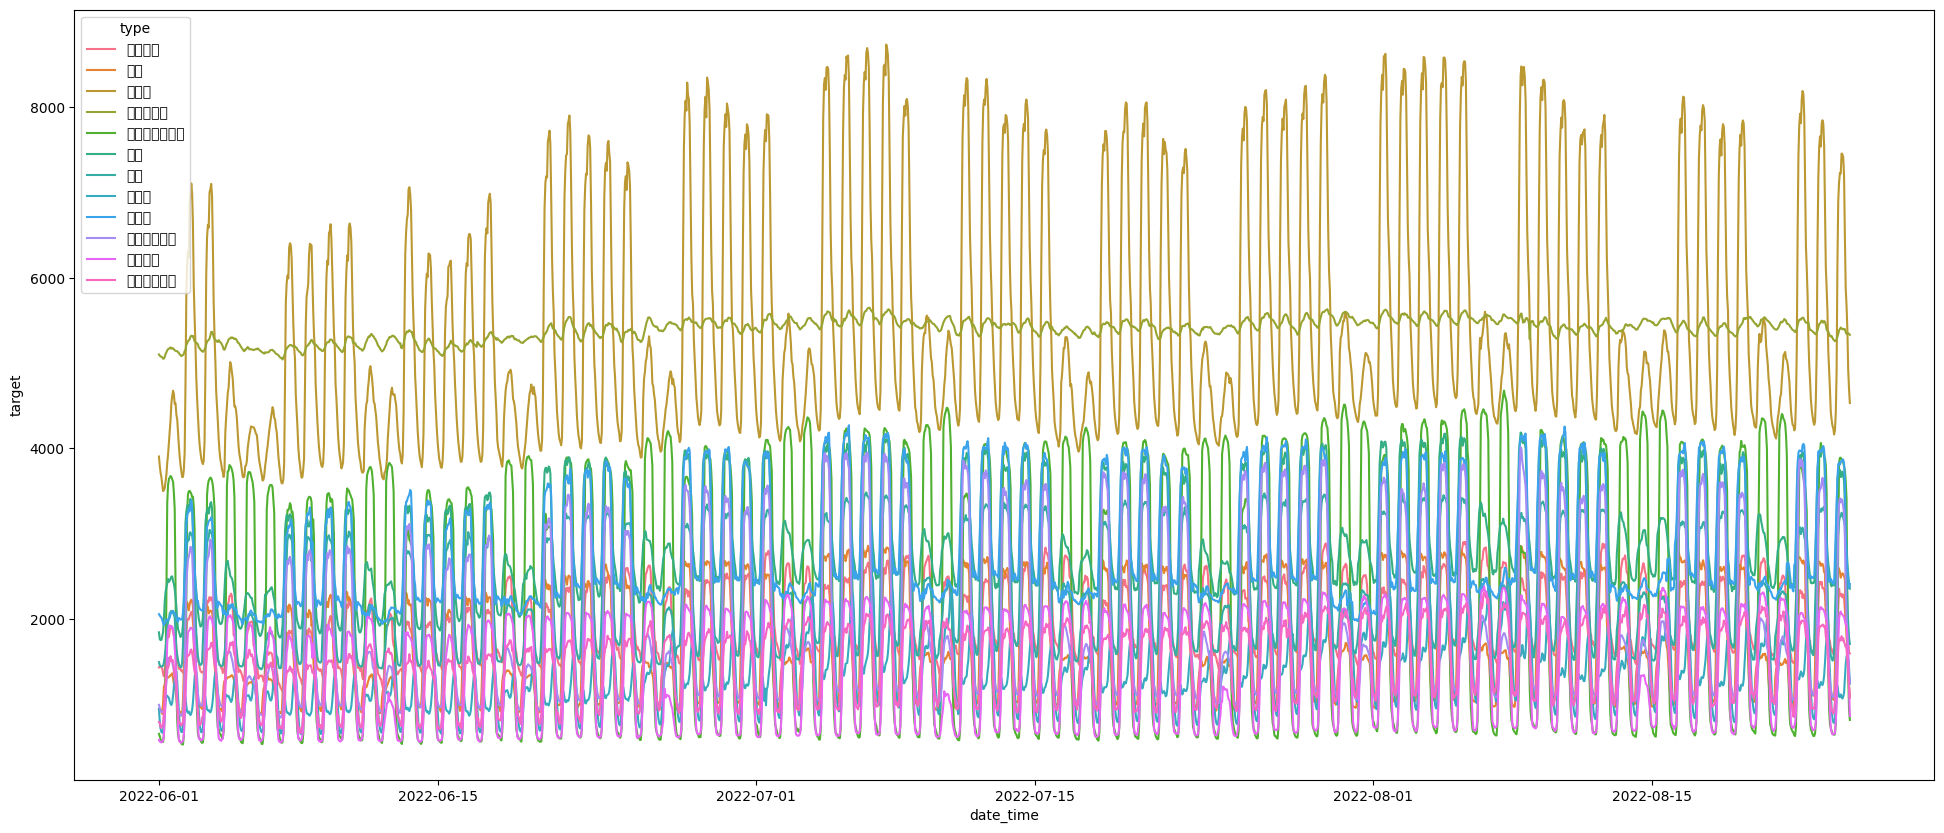

In [ ]:
train.date_time = pd.to_datetime(train.date_time)

plt.figure(figsize=(24, 10))
sns.lineplot(data=train, x='date_time', y='target', hue='type', errorbar=None)
plt.show()

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

#### 결측치 처리

In [ ]:
# 결측치가 있는 column
train.precipitation = train.precipitation.fillna(0) # 비가 안왔겠지
train.windspeed = train.windspeed.interpolate()
train.humidity = train.humidity.interpolate()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num_date_time  204000 non-null  object        
 1   num            204000 non-null  int64         
 2   date_time      204000 non-null  datetime64[ns]
 3   temperature    204000 non-null  float64       
 4   precipitation  204000 non-null  float64       
 5   windspeed      204000 non-null  float64       
 6   humidity       204000 non-null  float64       
 7   target         204000 non-null  float64       
 8   type           204000 non-null  object        
 9   area1          204000 non-null  float64       
 10  area2          204000 non-null  float64       
 11  solar          204000 non-null  float64       
 12  ESS            204000 non-null  float64       
 13  PCS            204000 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(

In [ ]:
# categorical feature encoding
train = pd.get_dummies(data=train, columns=['type'])
train

,num_date_time,num,date_time,temperature,precipitation,windspeed,humidity,target,area1,area2,...,type_대학교,type_데이터센터,type_백화점및아울렛,type_병원,type_상용,type_아파트,type_연구소,type_지식산업센터,type_할인마트,type_호텔및리조트
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,881.04,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1
203996,100_20220824 20,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,798.96,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1
203997,100_20220824 21,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,825.12,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1
203998,100_20220824 22,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,640.08,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1


#### feature extraction

- 차원의 저주를 해결하거나, 데이터의 feature 조합을 이용하는 새로운 feature를 생성할 때, PCA를 사용합니다.

- 분석에 사용할 feature를 선택하는 과정도 포함합니다.

In [ ]:
# PCA 적용
if feature_reducing:
    from sklearn.decomposition import PCA

    pca = PCA(n_components=0.90,   # 원본 데이터의 정보를 90% 표현하는 공간의 차원
              whiten=True,  # standardization
              random_state=42)

    pca_df = pd.DataFrame(data=pca.fit_transform(X_train), columns=[f'PC{i}' for i in range(1, X_train.shape[1])])
    display(pca_df)

    #pca.transform(X_val)

### 4. 학습 데이터 분할

In [ ]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
from sklearn.model_selection import train_test_split

X = train.drop(columns=['num_date_time', 'date_time', 'target'])
y = train.target

# for OOF-prediction split 5% of data as validation dataset.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(193800, 22) (193800,) (10200, 22) (10200,)


### 5. 학습 및 평가

In [ ]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)
model = LGBMRegressor()

In [ ]:
print("\nFitting LightGBM...")
model.fit(X_train, y_train)


Fitting LightGBM...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 193800, number of used features: 22
[LightGBM] [Info] Start training from score 2451.946577


LGBMRegressor()

In [ ]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred)*2)/(np.abs(true) + np.abs(pred))) * 100

evaluation_metric = SMAPE

In [ ]:
print("Prediction")
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)


train_score = evaluation_metric(y_train, pred_train)
val_score = evaluation_metric(y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % val_score)

Prediction
Train Score : 24.8146
Test Score : 25.8022


### 6. Hyper-parameter Tuning

In [ ]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    #num_leaves = trial.suggest_categorical('num_leaves', [128, 256, 512]) # Grid Search
    num_leaves = trial.suggest_int('num_leaves', 128, 512) # Grid Search
    max_depth = trial.suggest_int('max_depth', 10, 15)
    #learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)


    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = LGBMRegressor(num_leaves=num_leaves,
                          max_depth=max_depth,
                          learning_rate=0.25,
                          random_state=42)

    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K, random_state=42, shuffle=True)
    losses = []

    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)


    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
K = 5   # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=50)

[I 2023-10-11 07:45:52,538] A new study created in memory with name: no-name-57a3de03-b541-4afa-8b00-86d188196e12


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2453.481225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[I 2023-10-11 07:46:05,359] Trial 0 finished with value: 21.686538098196586 and parameters: {'num_leaves': 170, 'max_depth': 15}. Best is trial 0 with value: 21.686538098196586.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:46:21,343] Trial 1 finished with value: 21.292193502464063 and parameters: {'num_leaves': 282, 'max_depth': 13}. Best is trial 1 with value: 21.292193502464063.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2453.481225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021606 seconds.
You can set `force_col_wise=true` to remove th

[I 2023-10-11 07:46:33,077] Trial 2 finished with value: 21.805260252841958 and parameters: {'num_leaves': 148, 'max_depth': 15}. Best is trial 1 with value: 21.292193502464063.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 155040, number of us

[I 2023-10-11 07:46:49,609] Trial 3 finished with value: 21.405505251610997 and parameters: {'num_leaves': 221, 'max_depth': 14}. Best is trial 1 with value: 21.292193502464063.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2023-10-11 07:47:05,827] Trial 4 finished with value: 21.453669712224034 and parameters: {'num_leaves': 255, 'max_depth': 12}. Best is trial 1 with value: 21.292193502464063.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:47:23,738] Trial 5 finished with value: 21.657368983483423 and parameters: {'num_leaves': 400, 'max_depth': 10}. Best is trial 1 with value: 21.292193502464063.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:47:44,659] Trial 6 finished with value: 21.085320277241692 and parameters: {'num_leaves': 405, 'max_depth': 13}. Best is trial 6 with value: 21.085320277241692.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:48:14,638] Trial 7 finished with value: 20.9588260978445 and parameters: {'num_leaves': 396, 'max_depth': 14}. Best is trial 7 with value: 20.9588260978445.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2023-10-11 07:48:40,250] Trial 8 finished with value: 21.38056567234407 and parameters: {'num_leaves': 429, 'max_depth': 11}. Best is trial 7 with value: 20.9588260978445.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:49:01,104] Trial 9 finished with value: 20.893328143596555 and parameters: {'num_leaves': 505, 'max_depth': 14}. Best is trial 9 with value: 20.893328143596555.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:49:21,539] Trial 10 finished with value: 21.137440948589493 and parameters: {'num_leaves': 512, 'max_depth': 12}. Best is trial 9 with value: 20.893328143596555.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:49:42,189] Trial 11 finished with value: 20.888637870435804 and parameters: {'num_leaves': 503, 'max_depth': 14}. Best is trial 11 with value: 20.888637870435804.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:50:03,405] Trial 12 finished with value: 20.8518676192728 and parameters: {'num_leaves': 510, 'max_depth': 14}. Best is trial 12 with value: 20.8518676192728.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:50:23,490] Trial 13 finished with value: 20.909167106630115 and parameters: {'num_leaves': 463, 'max_depth': 14}. Best is trial 12 with value: 20.8518676192728.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:50:40,000] Trial 14 finished with value: 21.011836454665236 and parameters: {'num_leaves': 338, 'max_depth': 15}. Best is trial 12 with value: 20.8518676192728.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:50:56,863] Trial 15 finished with value: 21.156333388337732 and parameters: {'num_leaves': 333, 'max_depth': 13}. Best is trial 12 with value: 20.8518676192728.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:51:16,249] Trial 16 finished with value: 20.922115028923145 and parameters: {'num_leaves': 466, 'max_depth': 14}. Best is trial 12 with value: 20.8518676192728.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2023-10-11 07:51:36,727] Trial 17 finished with value: 21.054821654909375 and parameters: {'num_leaves': 465, 'max_depth': 13}. Best is trial 12 with value: 20.8518676192728.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:51:54,826] Trial 18 finished with value: 20.9432278839096 and parameters: {'num_leaves': 369, 'max_depth': 15}. Best is trial 12 with value: 20.8518676192728.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:52:13,073] Trial 19 finished with value: 21.165019702574817 and parameters: {'num_leaves': 444, 'max_depth': 12}. Best is trial 12 with value: 20.8518676192728.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:52:31,365] Trial 20 finished with value: 21.371016313094927 and parameters: {'num_leaves': 509, 'max_depth': 11}. Best is trial 12 with value: 20.8518676192728.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:52:52,431] Trial 21 finished with value: 20.868285550586172 and parameters: {'num_leaves': 495, 'max_depth': 14}. Best is trial 12 with value: 20.8518676192728.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:53:11,748] Trial 22 finished with value: 20.88848262781155 and parameters: {'num_leaves': 472, 'max_depth': 14}. Best is trial 12 with value: 20.8518676192728.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:53:31,795] Trial 23 finished with value: 20.848053092351332 and parameters: {'num_leaves': 473, 'max_depth': 15}. Best is trial 23 with value: 20.848053092351332.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:53:51,782] Trial 24 finished with value: 20.831266214355445 and parameters: {'num_leaves': 437, 'max_depth': 15}. Best is trial 24 with value: 20.831266214355445.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:54:12,125] Trial 25 finished with value: 20.92052383368962 and parameters: {'num_leaves': 429, 'max_depth': 15}. Best is trial 24 with value: 20.831266214355445.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:54:30,993] Trial 26 finished with value: 20.936154165091246 and parameters: {'num_leaves': 434, 'max_depth': 15}. Best is trial 24 with value: 20.831266214355445.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 155040, number of us

[I 2023-10-11 07:54:47,306] Trial 27 finished with value: 21.142168373323535 and parameters: {'num_leaves': 298, 'max_depth': 15}. Best is trial 24 with value: 20.831266214355445.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:55:05,691] Trial 28 finished with value: 20.996557851741688 and parameters: {'num_leaves': 378, 'max_depth': 15}. Best is trial 24 with value: 20.831266214355445.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:55:25,409] Trial 29 finished with value: 20.860705270774595 and parameters: {'num_leaves': 482, 'max_depth': 15}. Best is trial 24 with value: 20.831266214355445.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:55:42,701] Trial 30 finished with value: 20.962811432579496 and parameters: {'num_leaves': 358, 'max_depth': 15}. Best is trial 24 with value: 20.831266214355445.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:56:03,763] Trial 31 finished with value: 20.857708758918132 and parameters: {'num_leaves': 483, 'max_depth': 15}. Best is trial 24 with value: 20.831266214355445.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:56:23,012] Trial 32 finished with value: 20.87898058148963 and parameters: {'num_leaves': 451, 'max_depth': 15}. Best is trial 24 with value: 20.831266214355445.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:56:42,522] Trial 33 finished with value: 20.81866194873119 and parameters: {'num_leaves': 485, 'max_depth': 15}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can 

[I 2023-10-11 07:56:55,862] Trial 34 finished with value: 21.53812627678608 and parameters: {'num_leaves': 190, 'max_depth': 14}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:57:14,618] Trial 35 finished with value: 20.863232187706497 and parameters: {'num_leaves': 418, 'max_depth': 15}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:57:34,900] Trial 36 finished with value: 20.9581039479609 and parameters: {'num_leaves': 450, 'max_depth': 14}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004
[Li

[I 2023-10-11 07:57:49,679] Trial 37 finished with value: 21.260601211326634 and parameters: {'num_leaves': 256, 'max_depth': 15}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2023-10-11 07:58:08,844] Trial 38 finished with value: 21.03683085850241 and parameters: {'num_leaves': 490, 'max_depth': 13}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:58:27,000] Trial 39 finished with value: 21.001873846324067 and parameters: {'num_leaves': 405, 'max_depth': 14}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:58:48,084] Trial 40 finished with value: 21.05128959329346 and parameters: {'num_leaves': 481, 'max_depth': 13}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:59:09,312] Trial 41 finished with value: 20.857708758918132 and parameters: {'num_leaves': 483, 'max_depth': 15}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2453.481225
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] 

[I 2023-10-11 07:59:20,342] Trial 42 finished with value: 21.949189818342212 and parameters: {'num_leaves': 131, 'max_depth': 15}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:59:40,323] Trial 43 finished with value: 20.867618382694992 and parameters: {'num_leaves': 454, 'max_depth': 15}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 07:59:58,798] Trial 44 finished with value: 20.961209658648926 and parameters: {'num_leaves': 421, 'max_depth': 14}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 08:00:19,349] Trial 45 finished with value: 20.858999983491465 and parameters: {'num_leaves': 494, 'max_depth': 15}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2023-10-11 08:00:40,136] Trial 46 finished with value: 20.955085174460642 and parameters: {'num_leaves': 473, 'max_depth': 14}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 08:00:56,631] Trial 47 finished with value: 21.623588679451917 and parameters: {'num_leaves': 512, 'max_depth': 10}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 08:01:14,779] Trial 48 finished with value: 20.9964575757838 and parameters: {'num_leaves': 391, 'max_depth': 14}. Best is trial 33 with value: 20.81866194873119.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 155040, number of used features: 22
[LightGBM] [Info] Start training from score 2452.527687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-11 08:01:33,641] Trial 49 finished with value: 20.886391372079125 and parameters: {'num_leaves': 440, 'max_depth': 15}. Best is trial 33 with value: 20.81866194873119.


In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_num_leaves,state
0,0,21.686538,2023-10-11 07:45:52.542566,2023-10-11 07:46:05.359204,0 days 00:00:12.816638,15,170,COMPLETE
1,1,21.292194,2023-10-11 07:46:05.360921,2023-10-11 07:46:21.342670,0 days 00:00:15.981749,13,282,COMPLETE
2,2,21.805260,2023-10-11 07:46:21.347005,2023-10-11 07:46:33.077067,0 days 00:00:11.730062,15,148,COMPLETE
3,3,21.405505,2023-10-11 07:46:33.083449,2023-10-11 07:46:49.609397,0 days 00:00:16.525948,14,221,COMPLETE
4,4,21.453670,2023-10-11 07:46:49.621810,2023-10-11 07:47:05.827072,0 days 00:00:16.205262,12,255,COMPLETE
5,5,21.657369,2023-10-11 07:47:05.828733,2023-10-11 07:47:23.738681,0 days 00:00:17.909948,10,400,COMPLETE
6,6,21.085320,2023-10-11 07:47:23.740386,2023-10-11 07:47:44.658679,0 days 00:00:20.918293,13,405,COMPLETE
7,7,20.958826,2023-10-11 07:47:44.661661,2023-10-11 07:48:14.638054,0 days 00:00:29.976393,14,396,COMPLETE
8,8,21.380566,2023-10-11 07:48:14.645832,2023-10-11 07:48:40.250071,0 days 00:00:25.604239,11,429,COMPLETE
9,9,20.893328,2023-10-11 07:48:40.251808,2023-10-11 07:49:01.103882,0 days 00:00:20.852074,14,505,COMPLETE


In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 20.8187
Best params:  {'num_leaves': 485, 'max_depth': 15}


In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [ ]:
# Make KFold OOF prediction
def oof_preds(best_model):

    # make KFold
    folds = KFold(n_splits=K, random_state=42, shuffle=True)
    final_preds = []
    losses = []
    # fitting with best_model
    for i, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        print(f"========== Fold {i+1} ==========")
        best_model.fit(X_train, y_train)
        preds = best_model.predict(X_val)
        test_preds = best_model.predict(X_test)
        final_preds.append(test_preds)
        loss = evaluation_metric(y_val, preds)

        losses.append(loss)

    avg_loss = np.mean(losses)
    print(f"Loss : {avg_loss:.4f}")
    return final_preds

In [ ]:
test.info() # 결측치 없음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   num            16800 non-null  int64  
 2   date_time      16800 non-null  object 
 3   temperature    16800 non-null  float64
 4   precipitation  16800 non-null  float64
 5   windspeed      16800 non-null  float64
 6   humidity       16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


In [ ]:
## X_test 만들기 : 앞서했던 전처리를 동일하게 적용해주면 됨.
# 결측치가 있는 column
# train.precipitation = train.precipitation.fillna(0) # 비가 안왔겠지
# train.windspeed = train.windspeed.interpolate()
# train.humidity = train.humidity.interpolate()
# train.info()

X_test = pd.merge(test, building_info, on='num') # inner join
# categorical feature encoding
X_test = pd.get_dummies(data=X_test, columns=['type'])
X_test = X_test.drop(columns=['num_date_time', 'date_time'])
X_test

,num,temperature,precipitation,windspeed,humidity,area1,area2,solar,ESS,PCS,...,type_대학교,type_데이터센터,type_백화점및아울렛,type_병원,type_상용,type_아파트,type_연구소,type_지식산업센터,type_할인마트,type_호텔및리조트
0,1,23.5,0.0,2.2,72,110634.00,39570.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,23.0,0.0,0.9,72,110634.00,39570.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,22.7,0.0,1.5,75,110634.00,39570.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,22.1,0.0,1.3,78,110634.00,39570.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,21.8,0.0,1.0,77,110634.00,39570.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,22.5,0.0,0.9,84,57497.84,40035.23,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
16796,100,20.7,0.0,0.4,95,57497.84,40035.23,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
16797,100,20.2,0.0,0.4,98,57497.84,40035.23,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
16798,100,20.1,0.0,1.1,97,57497.84,40035.23,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
best_params = study.best_trial.params

# define best model
best_model = LGBMRegressor(**best_params,
                           random_state=42)

# model finalization : 가장 일반적으로 좋은 예측 성능을 냈던 모델로, 전체 데이터 트레이닝.
if finalize == 'kfolds':
    preds = oof_preds(best_model)
    preds = np.mean(preds, axis=0)
else:
    best_model.fit(X, y)
    preds = best_model.predict(X_test)
preds

========== Fold 1 ==========
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 163200, number of used features: 22
[LightGBM] [Info] Start training from score 2453.452806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

array([2374.53976168, 1994.49225826, 1871.39831301, ...,  442.93850801,
        519.94761214,  448.67791086])

In [ ]:
submission = pd.read_csv(base_path + 'sample_submission.csv')
submission['answer'] = preds

In [ ]:
submission.to_csv("submission.csv", index=False)